In [1]:
import numpy as np 
import matplotlib.pyplot as plt

from prml.utils.datasets import RegressionDataGenerator

from prml.linear_regression import (
    LinearRegression,
    Ridge,
    BayesianLinearRegression
)

# Utils

In [4]:
# Function
def f(x):
    return 3*np.sin(x)
    
# Color maps 
cmaps = [[0.122, 0.467, 0.706],"orange","green"]

# Plot Prediction 
def plot_prediction(X_tr,y_tr,regressor,title,lower = 0,upper = 2*np.pi):
    X = np.linspace(lower,upper,100).reshape(-1,1)
    y_pred = regressor.predict(X) 
    y_true = f(X)
    
    rmse = np.mean((y_true-y_pred)**2)**0.5
    print(f"RMSE : {rmse}")
    
    fig,ax = plt.subplots(1,1,figsize = (10,7))
    ax.plot(X,y_pred,label="Predict",color=cmaps[0])
    ax.plot(X,y_true,label="Ground Truth",color=cmaps[1])
    ax.scatter(X_tr,y_tr,label="Training Data",color=cmaps[2])
    ax.set_title(title)
    
    plt.legend()
    plt.show()
    

# Plot Prediction with Std 
def plot_prediction_with_std(X_tr,y_tr,bayes_regressor,title,lower = 0,upper = 2*np.pi):
    X = np.linspace(lower,upper,100).reshape(-1,1)
    y_pred,y_std = bayes_regressor.predict(X,return_std=True)
    y_true = f(X)
    
    rmse = np.mean((y_true-y_pred)**2)**0.5
    print(f"RMSE : {rmse}")
    
    fig,ax = plt.subplots(1,1,figsize = (10,7))
    ax.plot(X,y_pred,label="Predict",color=cmaps[0])
    
    y_pred_upper = y_pred + y_std
    y_pred_lower = y_pred - y_std 
    ax.fill_between(X.ravel(),y_pred_lower.ravel(),y_pred_upper.ravel(),alpha=0.3,color=cmaps[0])
    
    ax.plot(X,y_true,label="Ground Truth",color=cmaps[1])
    ax.scatter(X_tr,y_tr,label="Training Data",color=cmaps[2])
    ax.set_title(title)
    
    plt.legend()
    plt.show()

In [5]:
generator = RegressionDataGenerator(f)

# Maximum Likelihood

where $\Phi$ is a design matrix, $T$ is target matrix <br> 
<h3>
    $$W_{ML} = (\Phi^T\Phi)^{-1}\Phi^T T$$ <br> 
    $$\frac{1}{\beta_{ML}} = \frac{1}{NK} \sum_{n = 1}^N ||t_n - W^T\phi(x_n)||^2$$ 
</h3>

In [8]:
X_tr,y_tr = generator(100,std = 0.75)
mu = np.random.rand(30)*6 - 3
s = np.random.rand(30)*5

RMSE : 0.7381362532763087


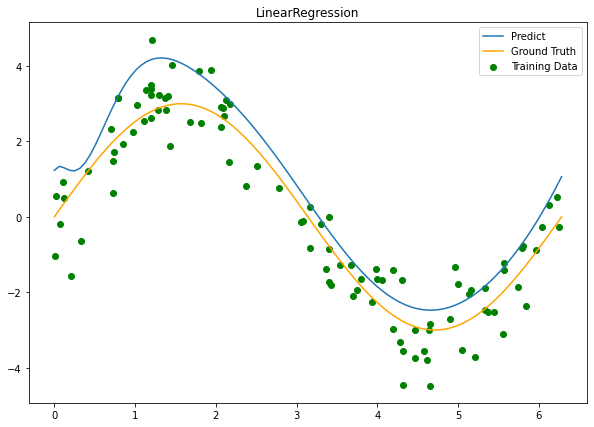

In [9]:
lr = LinearRegression(mu = mu,s = s)
lr.fit(X_tr,y_tr)
plot_prediction(X_tr,y_tr,lr,"LinearRegression")

# Ridge
<p>
    almost same as LinearRegression but it has a regularization term. 
</p>

RMSE : 0.2776678349897448


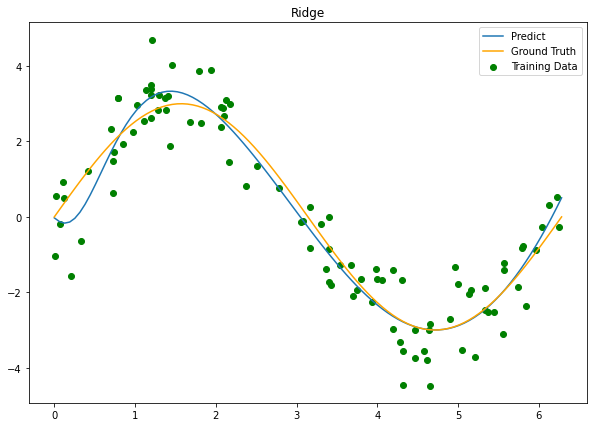

In [10]:
ridge = Ridge(lamda = 1e-8,mu = mu,s = s)  
ridge.fit(X_tr,y_tr)

plot_prediction(X_tr,y_tr,ridge,"Ridge")

# Bayesian Linear Regression

## Prior Distributin for Weight
### $$p(w|\alpha) = \mathcal{N}(w|0,\alpha^{-1}I)$$

<br> 

## Posterior Distribution for Weights
### $$p(w|t) = \mathcal{N}(w|m_N,S_N)$$
### where $$m_N = \beta S_N \Phi^\top t$$
### $$S_N^{-1} = \alpha I + \beta \Phi^\top \Phi$$

<br> 

## Predictive Distribution 
### $$p(t|x) = \mathcal{N}(t|m_N^\top\phi(x),\sigma_N^2(x))$$
### where $$\sigma_N^2(x) = \frac{1}{\beta} + \phi(x)^\top S_N\phi(x)$$

<br> 

## Evidence 
### $$\ln{p(t|\alpha,\beta)} = \frac{M}{2}\ln{\alpha} + \frac{N}{2}\ln{\beta} - E(m_N) + \frac{1}{2}\ln{|S_N|} - \frac{N}{2}\ln{2\pi}$$
### where $$E(m_N) = \frac{\beta}{2}||t - \Phi m_N||^2 + \frac{\alpha}{2}m_N^\top m_N$$

<br> 

## Maximizing the evidence function 
Let $\lambda_i$ be eigenvalue of $\beta\Phi^\top\Phi$
<h3>
    $$\gamma = \sum_{i = 1}^M \frac{\lambda_i}{\alpha + \lambda_i}$$ <br> 
    $$\alpha = \frac{\gamma}{m_N^\top m_N}$$ <br> 
    $$\frac{1}{\beta} = \frac{1}{N - \gamma}||t - \Phi m_N||^2$$
</h3>

RMSE : 3.00786510875897


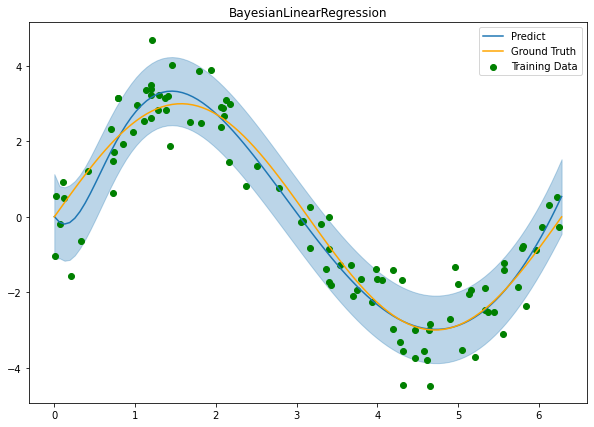

In [11]:
blr = BayesianLinearRegression(alpha = 1e-7,beta = 1.3,mu = mu,s = s)
blr.fit(X_tr,y_tr.ravel())

plot_prediction_with_std(X_tr,y_tr,blr,"BayesianLinearRegression")

RMSE : 3.006724781803714


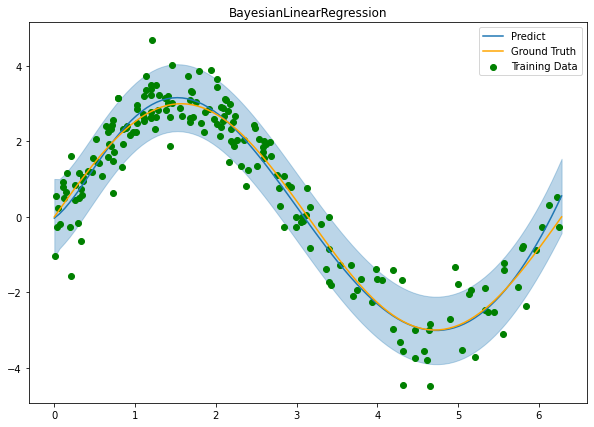

In [12]:
# partial fit

X_new,y_new = generator(100,lower = 0,upper = np.pi,std = 0.5)

blr.partial_fit(X_new,y_new.ravel())
plot_prediction_with_std(np.concatenate([X_tr,X_new]),
                         np.concatenate([y_tr,y_new]),
                         blr,"BayesianLinearRegression",lower = 0,upper = 2*np.pi)

Optimized alpha : 7.812236015849574e-05
Optimized beta : 1.7497806756281704
RMSE : 2.991233643676911


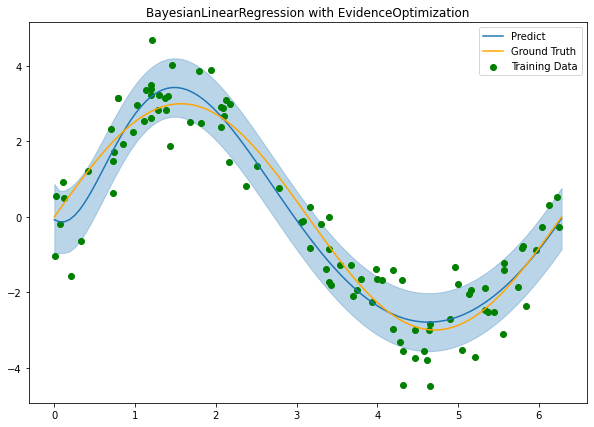

In [13]:
# With Evidence Optimization 

blr = BayesianLinearRegression(alpha = 10,beta = 10,mu = mu,s = s)
blr.fit(X_tr,y_tr.ravel(),optimize_evidence = True,max_iter = 100,threshold = 1e-8)
print(f"Optimized alpha : {blr.alpha}")
print(f"Optimized beta : {blr.beta}")

plot_prediction_with_std(X_tr,y_tr,blr,"BayesianLinearRegression with EvidenceOptimization")